# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8,
    shuffle=False
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, 
                        input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = True
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Dense(128,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, 
                       activation='softmax'))
print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 128)         262272    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 256)         33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6

In [5]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator #,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 108s 260ms/step - loss: 1.5687 - acc: 0.3837 - val_loss: 2.5005 - val_acc: 0.1629
Epoch 2/30
380/380 [==============================] - 96s 253ms/step - loss: 0.9014 - acc: 0.6411 - val_loss: 1.9217 - val_acc: 0.2037
Epoch 3/30
380/380 [==============================] - 97s 256ms/step - loss: 0.6719 - acc: 0.7419 - val_loss: 0.6706 - val_acc: 0.7475
Epoch 4/30
380/380 [==============================] - 97s 256ms/step - loss: 0.5432 - acc: 0.7937 - val_loss: 0.4964 - val_acc: 0.8004
Epoch 5/30
380/380 [==============================] - 97s 254ms/step - loss: 0.4477 - acc: 0.8298 - val_loss: 0.4028 - val_acc: 0.8350
Epoch 6/30
380/380 [==============================] - 96s 252ms/step - loss: 0.3832 - acc: 0.8539 - val_loss: 0.3459 - val_acc: 0.8656
Epoch 7/30
380/380 [==============================] - 97s 254ms/step - loss: 0.3410 - acc: 0.8717 - val_loss: 0.3516 - val_acc: 0.8564
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

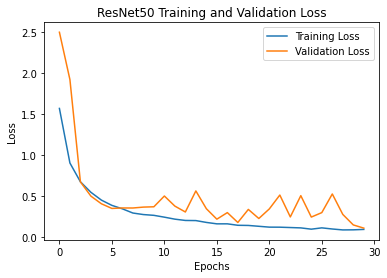

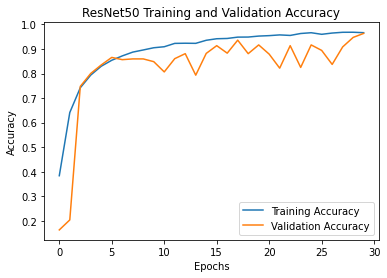

In [6]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 46ms/step - loss: 0.1050 - acc: 0.9633
Loss: 0.10495559126138687
Accuracy: 0.9633401036262512


In [8]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 Training classification report:\n", train_class_report)



380/380 [==============================] - 89s 232ms/step

ResNet50 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19744   0.18934   0.19331      1220
            covid19    0.21569   0.22124   0.21843      1243
             normal    0.18204   0.17895   0.18048      1235
       tuberculosis    0.19283   0.19316   0.19300      1170
    viral_pneumonia    0.18975   0.19554   0.19260      1212

           accuracy                        0.19572      6080
          macro avg    0.19555   0.19565   0.19556      6080
       weighted avg    0.19562   0.19572   0.19564      6080



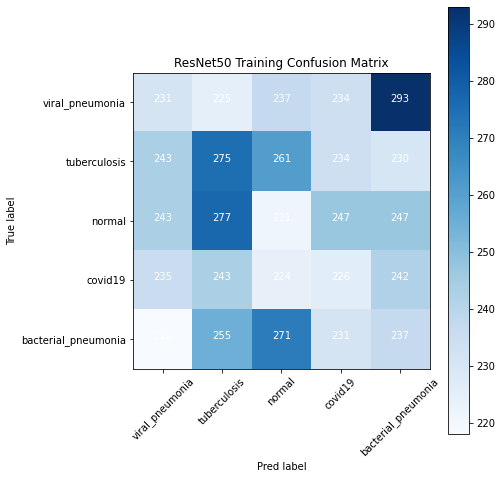

In [9]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [17]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(128,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(256,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_______________________________________________________

In [18]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 114s 283ms/step - loss: 1.0275 - acc: 0.5704 - val_loss: 0.6669 - val_acc: 0.7546
Epoch 2/30
380/380 [==============================] - 104s 273ms/step - loss: 0.5659 - acc: 0.7788 - val_loss: 0.5132 - val_acc: 0.7953
Epoch 3/30
380/380 [==============================] - 104s 272ms/step - loss: 0.4524 - acc: 0.8240 - val_loss: 0.5545 - val_acc: 0.7637
Epoch 4/30
380/380 [==============================] - 104s 273ms/step - loss: 0.3849 - acc: 0.8528 - val_loss: 0.4443 - val_acc: 0.8045
Epoch 5/30
380/380 [==============================] - 104s 273ms/step - loss: 0.3377 - acc: 0.8687 - val_loss: 0.8166 - val_acc: 0.6833
Epoch 6/30
380/380 [==============================] - 103s 272ms/step - loss: 0.3182 - acc: 0.8770 - val_loss: 0.5325 - val_acc: 0.7556
Epoch 7/30
380/380 [==============================] - 104s 273ms/step - loss: 0.2869 - acc: 0.8865 - val_loss: 0.3931 - val_acc: 0.8167
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

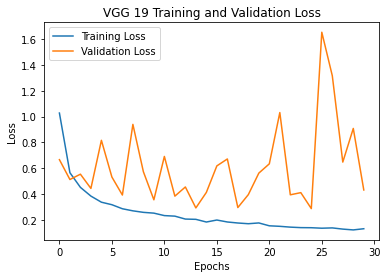

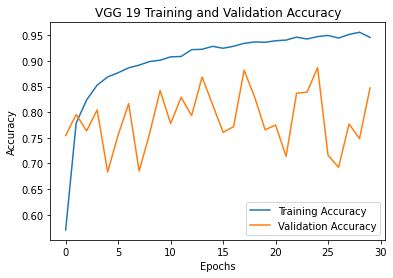

In [19]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 8s 62ms/step - loss: 0.4323 - acc: 0.8473
Loss: 0.4322642982006073
Accuracy: 0.8472505211830139


In [21]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 Training classification report:\n", train_class_report)



380/380 [==============================] - 82s 216ms/step

VGG 19 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21727   0.19180   0.20374      1220
            covid19    0.21849   0.18825   0.20225      1243
             normal    0.20130   0.22510   0.21254      1235
       tuberculosis    0.18865   0.19316   0.19088      1170
    viral_pneumonia    0.20769   0.23185   0.21910      1212

           accuracy                        0.20609      6080
          macro avg    0.20668   0.20603   0.20570      6080
       weighted avg    0.20686   0.20609   0.20581      6080



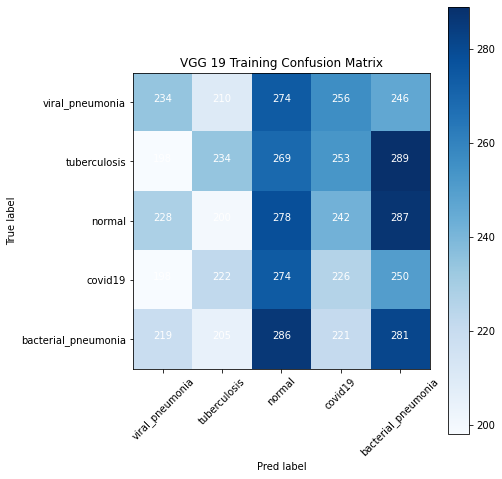

In [22]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [10]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Dense(768,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(256,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 5, 5, 768)         1573632   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 768)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 5, 5, 256)         196864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_______________________________________________________

In [12]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback,
)

Epoch 1/30
380/380 [==============================] - 112s 276ms/step - loss: 1.3657 - acc: 0.4211 - val_loss: 1.1091 - val_acc: 0.5418
Epoch 2/30
380/380 [==============================] - 94s 248ms/step - loss: 0.8646 - acc: 0.6465 - val_loss: 0.7483 - val_acc: 0.6721
Epoch 3/30
380/380 [==============================] - 94s 248ms/step - loss: 0.6754 - acc: 0.7255 - val_loss: 0.6439 - val_acc: 0.7149
Epoch 4/30
380/380 [==============================] - 94s 247ms/step - loss: 0.5936 - acc: 0.7576 - val_loss: 0.6174 - val_acc: 0.7230
Epoch 5/30
380/380 [==============================] - 95s 248ms/step - loss: 0.4919 - acc: 0.8053 - val_loss: 0.5445 - val_acc: 0.7688
Epoch 6/30
380/380 [==============================] - 94s 247ms/step - loss: 0.4420 - acc: 0.8257 - val_loss: 0.5416 - val_acc: 0.7688
Epoch 7/30
380/380 [==============================] - 93s 245ms/step - loss: 0.4106 - acc: 0.8403 - val_loss: 0.5224 - val_acc: 0.7780
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

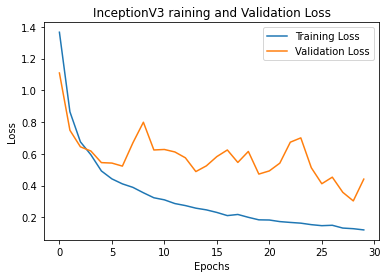

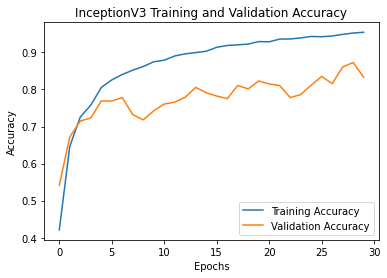

In [13]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 raining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 7s 54ms/step - loss: 0.4405 - acc: 0.8330
Loss: 0.44048866629600525
Accuracy: 0.8329938650131226


In [15]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 Training classification report:\n", train_class_report)



380/380 [==============================] - 92s 239ms/step

InceptionV3 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20191   0.20820   0.20500      1220
            covid19    0.21823   0.20998   0.21402      1243
             normal    0.21028   0.21538   0.21280      1235
       tuberculosis    0.19292   0.19573   0.19431      1170
    viral_pneumonia    0.20784   0.20132   0.20453      1212

           accuracy                        0.20625      6080
          macro avg    0.20623   0.20612   0.20613      6080
       weighted avg    0.20640   0.20625   0.20628      6080



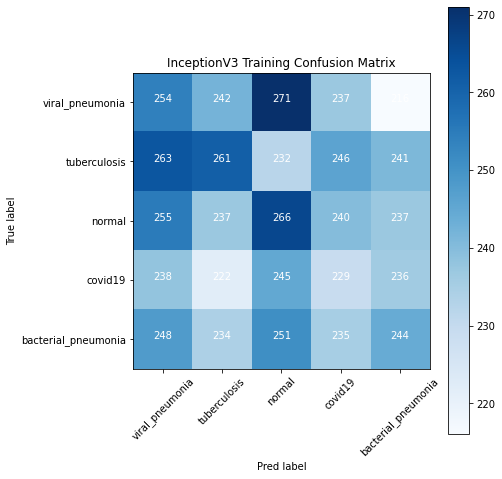

In [16]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()